In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multinomial

# Training

## Load train data

In [2]:
train_data = pd.read_csv('data/train_data/train_task_3_4.csv')
print(train_data.head())
len(train_data)

   QuestionId  UserId  AnswerId  IsCorrect  CorrectAnswer  AnswerValue
0         898    2111    280203          1              2            2
1         767    3062     55638          1              3            3
2         165    1156    386475          1              2            2
3         490    1653    997498          1              4            4
4         298    3912    578636          1              3            3


1382727

## Calculate entropy

In [3]:
# calculate entropy in each Question
entropy = train_data.groupby('QuestionId')['AnswerValue'].apply(lambda x : multinomial.entropy(1, x.value_counts(normalize=True)))
entropy

QuestionId
0       1.194456119275689
1      0.8760057656431736
2      1.3316632075619683
3      0.6954225533991737
4      1.3243211426168569
              ...        
943    0.9585435938032012
944    1.3124040297960131
945    1.2609343801953017
946    1.2367325970309815
947      1.08261445702246
Name: AnswerValue, Length: 948, dtype: object

## Calculate correct rate

In [4]:
# calculate correct rate in each Question
correctRate = train_data.groupby('QuestionId')['IsCorrect'].mean()
correctRate

QuestionId
0      0.443457
1      0.571429
2      0.385214
3      0.808757
4      0.401408
         ...   
943    0.566528
944    0.142857
945    0.422336
946    0.459459
947    0.617124
Name: IsCorrect, Length: 948, dtype: float64

## Calculate confidence

<Axes: >

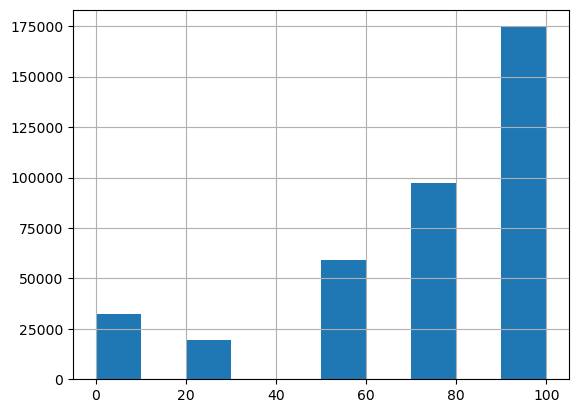

In [5]:
# load confidence data
confidence_data = pd.read_csv('data/metadata/answer_metadata_task_3_4.csv')
confidence_data['Confidence'].hist()

<Axes: >

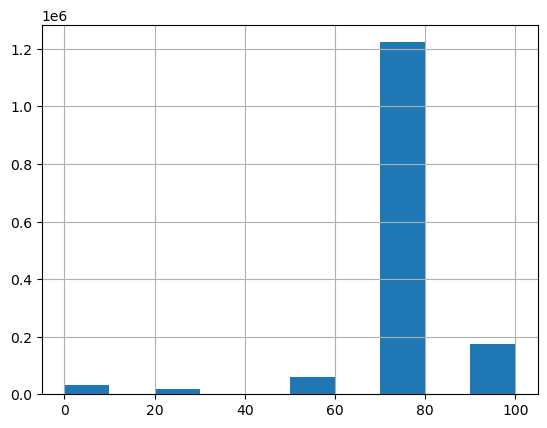

In [6]:
# preprocessing
# fill mean in NA
confidence_data['Confidence'] = confidence_data['Confidence'].fillna(confidence_data['Confidence'].mean())
confidence_data['Confidence'].hist()

In [7]:
# join train data table and confidance table
train_data_join_confidence = pd.merge(train_data, confidence_data, left_on='AnswerId', right_on='AnswerId')
train_data_join_confidence

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue,DateAnswered,Confidence,GroupId,QuizId,SchemeOfWorkId
0,898,2111,280203,1,2,2,2019-12-08 17:47:00.000,73.608704,95,86,52562.0
1,767,3062,55638,1,3,3,2019-10-27 20:54:00.000,25.000000,115,39,52562.0
2,165,1156,386475,1,2,2,2019-10-06 20:16:00.000,73.608704,101,39,52562.0
3,490,1653,997498,1,4,4,2020-02-27 17:40:00.000,73.608704,46,115,52562.0
4,298,3912,578636,1,3,3,2019-12-27 16:07:00.000,73.608704,314,78,52562.0
...,...,...,...,...,...,...,...,...,...,...,...
1382722,80,2608,57945,1,2,2,2019-11-28 15:22:00.000,73.608704,270,65,52562.0
1382723,707,2549,584230,0,2,1,2020-01-06 16:26:00.000,73.608704,269,109,52562.0
1382724,840,5901,1138956,1,1,1,2020-01-07 07:14:00.000,73.608704,270,66,52562.0
1382725,794,3854,1151183,0,1,3,2019-12-15 16:32:00.000,73.608704,339,9,52562.0


In [8]:
# calculate confidence mean in each Question
confidence = train_data_join_confidence.groupby('QuestionId')['Confidence'].mean()
confidence

QuestionId
0      70.912801
1      73.608704
2      71.716035
3      76.624144
4      71.122328
         ...    
943    77.013936
944    72.933064
945    73.248597
946    73.371335
947    73.882847
Name: Confidence, Length: 948, dtype: float64

## Ranking

In [9]:
# ranking by entropy
entropy_rank = entropy.rank(method='average', ascending=False).astype('int16')
entropy_rank.head()

QuestionId
0    484
1    844
2    124
3    908
4    150
Name: AnswerValue, dtype: int16

In [10]:
# ranking by correct rate
correctRate_rank = correctRate.rank(method='average', ascending=True).astype('int16')
correctRate_rank.head()

QuestionId
0    355
1    620
2    228
3    922
4    273
Name: IsCorrect, dtype: int16

In [11]:
# ranking by confidence
confidence_rank = confidence.rank(method='average', ascending=True).astype('int16')
confidence_rank.head()

QuestionId
0     71
1    429
2    127
3    899
4     82
Name: Confidence, dtype: int16

## Make ranking template for evaluation and submission

In [12]:
template = pd.read_csv('submission/template.csv')

# Use only entropy
template['ranking'] = entropy_rank.rank(method='first').astype('int16')
entropyRanking = template.copy()

# Use only correct rate
template['ranking'] = entropy_rank.rank(method='first').astype('int16')
correctRateRanking = template.copy()

# Use only confidence
template['ranking'] = confidence_rank.rank(method='first').astype('int16')
confidenceRanking = template.copy()

# Use entropy and correct rate
template['ranking'] = (entropy_rank+correctRate_rank).rank(method='first').astype('int16')
entropyAndCorrectRateRanking = template.copy()

# Use entropy and confidence
template['ranking'] = (entropy_rank+confidence_rank).rank(method='first').astype('int16')
entropyAndConfidenceRanking = template.copy()

# Use correct rate and confidence
template['ranking'] = (correctRate_rank+confidence_rank).rank(method='first').astype('int16')
correctRateAndConfidenceRanking = template.copy()

# Use every
template['ranking'] = (entropy_rank+correctRate_rank+confidence_rank).rank(method='first').astype('int16')
everyRanking = template.copy()

In [13]:
# I choose to use all parameters.
template = everyRanking
template.to_csv('submission/20182610.csv', index=False)

# Validation

## Load validation dataset

In [14]:
# load evaluators' score on "validation" set
eval_validation = pd.read_csv('data/test_data/quality_response_remapped_public.csv')
print(len(eval_validation))
eval_validation.head()

25


,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,0,0,909,318,2,2,2,1.0,2
1,16,16,285,609,2,2,2,2.0,2
2,48,48,132,271,1,2,2,2.0,1
3,38,38,704,127,2,2,1,2.0,2
4,33,33,16,586,1,1,2,2.0,2


## Find preference in validation dataset

<Axes: >

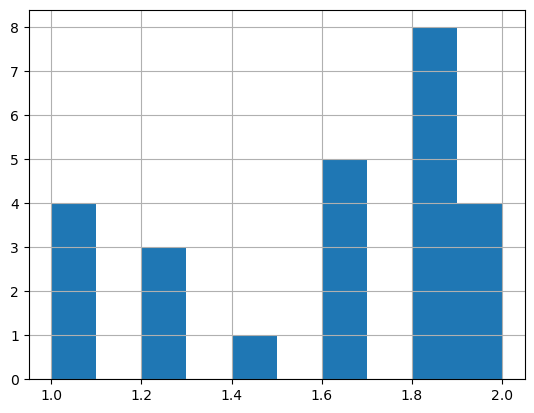

In [15]:
# take the average of 5 evaulators` scores
eval_validation['score'] = eval_validation.filter(regex='^T', axis = 1).mean(axis=1)
eval_validation['score'].hist()

In [16]:
def calc_preference(scores):
    preference = np.ones(len(scores), dtype=int)

    idx_two = scores > 1.5
    preference[idx_two] = 2
    
    return list(preference)

<Axes: >

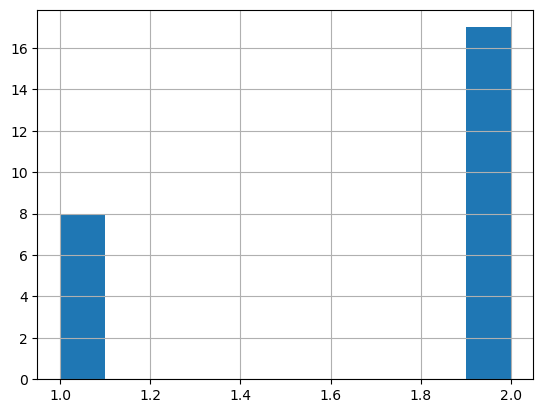

In [17]:
eval_validation['preference'] = calc_preference(eval_validation['score'])
# eval_dev[]
# eval_dev['score']
eval_validation['preference'].hist()

## Evaluate using validation dataset

In [18]:
def evaluate(truth, submission):
    # extract ranking
    left = list(truth.left)
    right = list(truth.right)
#     if len(left) != len(right):
#     message = 'left and right lengths are not the same'
#     sys.exit(message)

    submission_left = []
    submission_right = []
    submission_preference = []
    for idx in range(len(left)):
        submission_left.append(left[idx])
        submission_right.append(right[idx])
        ranking_left = submission[submission.QuestionId==left[idx]].ranking.values[0]
        ranking_right = submission[submission.QuestionId==right[idx]].ranking.values[0]
        preference = 1 if ranking_left < ranking_right else 2
        submission_preference.append(preference)
    return(submission_preference)

In [19]:
eval_validation['entropyPredict'] = evaluate(eval_validation, entropyRanking)
print('entropy: '+str(len(eval_validation[eval_validation['preference']!=eval_validation['entropyPredict']])/len(eval_validation)))
eval_validation['correctRatePredict'] = evaluate(eval_validation, correctRateRanking)
print('correct rate: '+str(len(eval_validation[eval_validation['preference']!=eval_validation['correctRatePredict']])/len(eval_validation)))
eval_validation['confidencePredict'] = evaluate(eval_validation, confidenceRanking)
print('confidence: '+str(len(eval_validation[eval_validation['preference']!=eval_validation['confidencePredict']])/len(eval_validation)))
eval_validation['entropyAndCorrectRatePredict'] = evaluate(eval_validation, entropyAndCorrectRateRanking)
print('entropy and correct rate: '+str(len(eval_validation[eval_validation['preference']!=eval_validation['entropyAndCorrectRatePredict']])/len(eval_validation)))
eval_validation['entropyAndConfidencePredict'] = evaluate(eval_validation, entropyAndConfidenceRanking)
print('entropy and confidence: '+str(len(eval_validation[eval_validation['preference']!=eval_validation['entropyAndConfidencePredict']])/len(eval_validation)))
eval_validation['correctRateAndConfidencePredict'] = evaluate(eval_validation, correctRateAndConfidenceRanking)
print('correct rate and confidence: '+str(len(eval_validation[eval_validation['preference']!=eval_validation['correctRateAndConfidencePredict']])/len(eval_validation)))
eval_validation['everyPredict'] = evaluate(eval_validation, everyRanking)
print('all: '+str(len(eval_validation[eval_validation['preference']!=eval_validation['everyPredict']])/len(eval_validation)))
eval_validation.head(25)

entropy: 0.16
correct rate: 0.16
confidence: 0.24
entropy and correct rate: 0.16
entropy and confidence: 0.12
correct rate and confidence: 0.2
all: 0.12


,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS,score,preference,entropyPredict,correctRatePredict,confidencePredict,entropyAndCorrectRatePredict,entropyAndConfidencePredict,correctRateAndConfidencePredict,everyPredict
0,0,0,909,318,2,2,2,1.0,2,1.8,2,2,2,1,2,2,1,2
1,16,16,285,609,2,2,2,2.0,2,2.0,2,2,2,1,2,2,2,2
2,48,48,132,271,1,2,2,2.0,1,1.6,2,2,2,2,2,2,2,2
3,38,38,704,127,2,2,1,2.0,2,1.8,2,2,2,1,2,2,2,2
4,33,33,16,586,1,1,2,2.0,2,1.6,2,2,2,2,2,2,2,2
5,17,17,56,865,2,1,2,2.0,2,1.8,2,2,2,2,2,2,2,2
6,27,27,233,478,1,1,1,1.0,2,1.2,1,1,1,1,1,1,1,1
7,41,41,877,620,2,2,2,2.0,2,2.0,2,2,2,2,2,2,2,2
8,5,5,246,733,1,1,1,2.0,1,1.2,1,1,1,1,1,1,1,1
9,35,35,668,741,1,1,1,1.0,1,1.0,1,2,2,1,2,1,1,1


# Test

## Load test dataset

In [20]:
eval_test = pd.read_csv('data/test_data/quality_response_remapped_private.csv')
print(len(eval_test))
eval_test.head()

25


,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,15,15,145,762,2,2,2,2.0,2
1,31,31,307,208,1,1,1,2.0,1
2,25,25,278,195,1,1,1,1.0,1
3,3,3,13,153,2,2,2,2.0,2
4,40,40,23,100,2,1,1,1.0,1


## Find preference in test dataset

<Axes: >

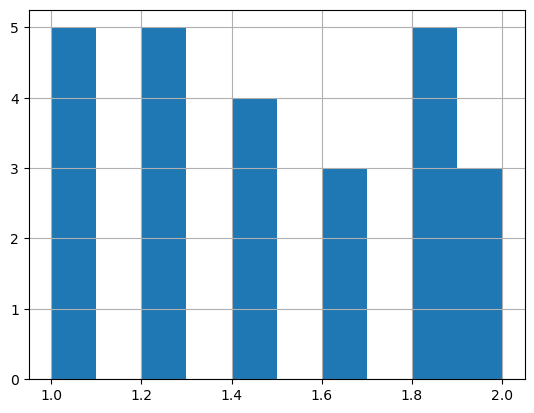

In [21]:
# take the average of scores by 5 evaulators
eval_test['score'] = eval_test.filter(regex='^T', axis = 1).mean(axis=1)
eval_test['score'].hist()

<Axes: >

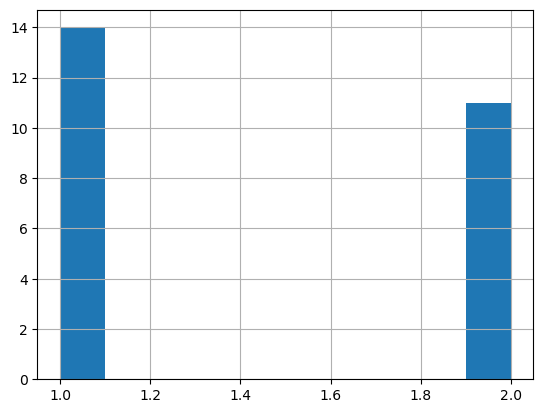

In [22]:
eval_test['preference'] = calc_preference(eval_test['score'])
eval_test['preference'].hist()

## Evaluate using test dataset

In [23]:
eval_test['entropyPredict'] = evaluate(eval_test, entropyRanking)
print('entropy: '+str(len(eval_test[eval_test['preference']!=eval_test['entropyPredict']])/len(eval_test)))
eval_test['correctRatePredict'] = evaluate(eval_test, correctRateRanking)
print('correct rate: '+str(len(eval_test[eval_test['preference']!=eval_test['correctRatePredict']])/len(eval_test)))
eval_test['confidencePredict'] = evaluate(eval_test, confidenceRanking)
print('confidence: '+str(len(eval_test[eval_test['preference']!=eval_test['confidencePredict']])/len(eval_test)))
eval_test['entropyAndCorrectRatePredict'] = evaluate(eval_test, entropyAndCorrectRateRanking)
print('entropy and correct rate: '+str(len(eval_test[eval_test['preference']!=eval_test['entropyAndCorrectRatePredict']])/len(eval_test)))
eval_test['entropyAndConfidencePredict'] = evaluate(eval_test, entropyAndConfidenceRanking)
print('entropy and confidence: '+str(len(eval_test[eval_test['preference']!=eval_test['entropyAndConfidencePredict']])/len(eval_test)))
eval_test['correctRateAndConfidencePredict'] = evaluate(eval_test, correctRateAndConfidenceRanking)
print('correct rate and confidence: '+str(len(eval_test[eval_test['preference']!=eval_test['correctRateAndConfidencePredict']])/len(eval_test)))
eval_test['everyPredict'] = evaluate(eval_test, everyRanking)
print('all: '+str(len(eval_test[eval_test['preference']!=eval_test['everyPredict']])/len(eval_test)))
eval_test.head(25)

entropy: 0.36
correct rate: 0.36
confidence: 0.28
entropy and correct rate: 0.36
entropy and confidence: 0.28
correct rate and confidence: 0.24
all: 0.24


,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS,score,preference,entropyPredict,correctRatePredict,confidencePredict,entropyAndCorrectRatePredict,entropyAndConfidencePredict,correctRateAndConfidencePredict,everyPredict
0,15,15,145,762,2,2,2,2.0,2,2.00,2,2,2,2,2,2,2,2
1,31,31,307,208,1,1,1,2.0,1,1.20,1,1,1,1,1,1,1,1
2,25,25,278,195,1,1,1,1.0,1,1.00,1,1,1,1,1,1,1,1
3,3,3,13,153,2,2,2,2.0,2,2.00,2,1,1,2,1,2,2,2
4,40,40,23,100,2,1,1,1.0,1,1.20,1,1,1,1,1,1,1,1
5,23,23,532,104,1,1,2,2.0,1,1.40,1,1,1,1,2,1,1,1
6,21,21,155,479,1,1,1,1.0,2,1.20,1,1,1,2,1,2,1,1
7,1,1,304,907,1,1,1,1.0,1,1.00,1,1,1,1,1,1,1,1
8,26,26,242,129,1,1,1,1.0,1,1.00,1,1,1,1,1,1,1,1
9,39,39,688,287,2,1,2,2.0,2,1.80,2,2,2,2,2,2,2,2
